# Spam Nachrichten
Spam-E-Mails oder -Nachrichten gehören zu der breiten Kategorie von unerwünschten Nachrichten, die ein Benutzer erhält. Spam belegt unerwünschten Speicherplatz und Bandbreite, verstärkt die Bedrohung durch Viren wie Trojaner und nutzt allgemein die Verbindung eines Benutzers zu sozialen Netzwerken aus.

Spam kann auch für Denial of Service (DOS)- oder Distributed Denial of Service (DDOS)-Angriffe verwendet werden. Um Spam-Nachrichten herauszufiltern, werden verschiedene Techniken eingesetzt, die sich meist auf inhaltsbasierte Filterung konzentrieren. Der Grund dafür ist, dass bestimmte Schlüsselwörter, Links oder Websites wiederholt massenhaft an Benutzer gesendet werden, was sie als Spam charakterisiert.

## Die Lösung: Text-Klassifikation

Vergleichsweise gesehen sind Sprachen für Algorithmen schwieriger zu interpretieren und zu analysieren als numerische Daten. Dies gilt aus mehreren Gründen:

1. Sätze sind nicht von fester Länge, sondern die meisten Algorithmen benötigen eine Standardgröße des Eingabevektors. Es wird also ein Padding benötigt, das dem größten Satz in den Korpora entspricht.
1. ML-Algorithmen können keine Wörter als Eingabe verstehen: Daher muss jedes Wort durch einen numerischen Wert dargestellt werden.

## Bag-of-Words-Modell

Ein Bag-of-Words-Modell ermöglicht es uns, Merkmale aus Textdaten zu extrahieren. Wie wir wissen, versteht ein Algorithmus die Sprache nicht. Daher müssen wir eine numerische Darstellung für die Wörter im Korpus verwenden. Diese numerische Repräsentation kann später einem beliebigen Algorithmus zur weiteren Analyse zugeführt werden.

Es wird "Bag-of-Words" genannt, weil die Reihenfolge der Wörter oder die Struktur des Satzes in diesem Modell verloren geht. Nur das Vorkommen oder Vorhandensein eines Wortes zählt.

Wir können uns das Modell so vorstellen - wir haben einen großen, anfangs leeren Beutel und ein Vokabular oder einen Korpus. Wir nehmen ein Wort nach dem anderen auf und legen es in den Beutel, wobei wir die Häufigkeit seines Vorkommens addieren, und wählen dann die häufigsten Wörter als Merkmale aus, die wir durch den Algorithmus unserer Wahl laufen lassen.

So wird die Ansicht gefördert, dass ähnliche Dokumente aus ähnlichen Arten von Wörtern bestehen.

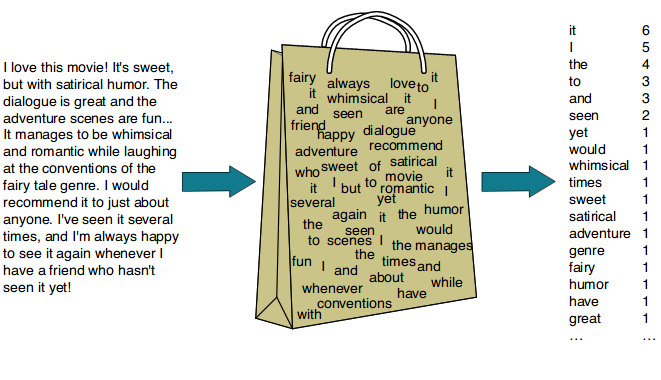

Datensatz

Der Datensatz, den wir in diesem Artikel verwenden werden, ist ein SMS-Spam-Sammlungsdatensatz. Er enthält über 5500 Nachrichten in englischer Sprache, wobei jede Nachricht in einer Spalte steht und die entsprechende Spalte daneben angibt, ob es sich bei dem Text um Ham oder Spam handelt.

Sie können den Datensatz hier finden. Der komplette Quellcode ist in diesem Repository zu finden.
Importieren des Datensatzes

Um den Datensatz in einen Pandas-Dataframe zu importieren, verwenden wir die unten stehenden Zeilen:

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
nltk.download('punkt')
dataset = pd.read_csv('/content/drive/MyDrive/vbg/spam.csv', encoding='latin-1');
dataset.dropna(how="any", inplace=True, axis=1)
dataset.columns = ['labels', 'message']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Hier sehen Sie einen Blick auf den Datensatz, an dem wir arbeiten. Wir wandeln die Beschriftungen später in Dummy-Variablen um.

In [53]:
dataset.head()

,labels,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [54]:
dataset.describe()

,labels,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [55]:
dataset.groupby('labels').describe()

message                                                               
         count unique                                                top freq
labels                                                                       
ham       4825   4516                             Sorry, I'll call later   30
spam       747    653  Please call our customer service representativ...    4

Hinzufügen der Nachrichtenlänge

In [56]:
dataset['message_len'] = dataset.message.apply(len)

Text(0.5, 0, 'Message Length')

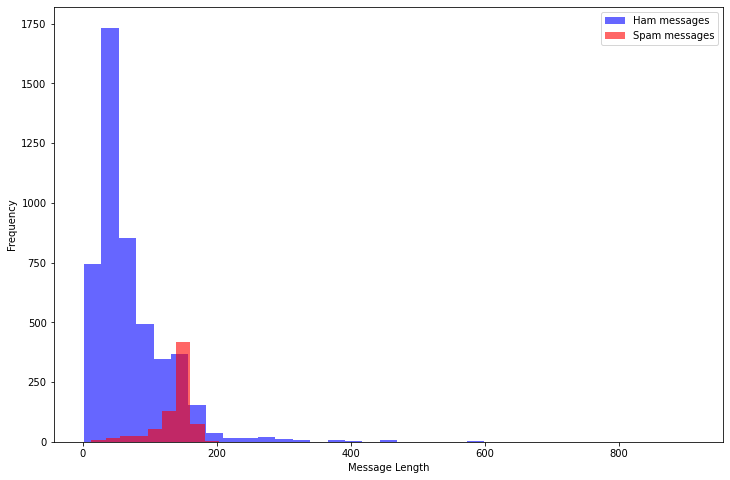

In [57]:
plt.figure(figsize=(12, 8))

dataset[dataset.labels=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
dataset[dataset.labels=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [58]:
dataset[dataset.labels=='ham'].describe()

,message_len
count,4825.000000
mean,71.023627
std,58.016023
min,2.000000
25%,33.000000
50%,52.000000
75%,92.000000
max,910.000000


In [59]:
dataset[dataset.labels=='spam'].describe()

,message_len
count,747.000000
mean,138.866131
std,29.183082
min,13.000000
25%,132.500000
50%,149.000000
75%,157.000000
max,224.000000


In [60]:
dataset[dataset.message_len == 910].message.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

## Vorverarbeitung der Daten
### Entfernen von Stoppwörtern

Stoppwörter beziehen sich auf die Wörter in einer Aussage, die ihr keine spezifische Bedeutung verleihen. Oft handelt es sich dabei um Präpositionen, Hilfsverben und Artikel (z. B. in, der, eine, ist). Da diese keinen Wert für unser Modell haben, müssen wir sie entfernen.

In [61]:
nltk.download('stopwords')
from nltk.corpus import stopwords
#stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
#dataset.rename(columns = {'v1': 'labels', 'v2': 'message'}, inplace = True)
 
data = []

for i in range(dataset.shape[0]):
    sms = dataset.iloc[i, 1]

    sms = re.sub('[^A-Za-z]', ' ', sms)

    sms = sms.lower()

    tokenized_sms = nltk.word_tokenize(sms)

   # print(tokenized_sms)
 
    sms_processed = []
    for word in tokenized_sms:
        if word not in set(stopwords.words('english')):
            sms_processed.append((word))

    sms_text = " ".join(sms_processed)
    data.append(sms_text)

In [63]:
data

['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think goes usf lives around though',
 'freemsg hey darling week word back like fun still tb ok xxx std chgs send rcv',
 'even brother like speak treat like aids patent',
 'per request melle melle oru minnaminunginte nurungu vettam set callertune callers press copy friends callertune',
 'winner valued network customer selected receivea prize reward claim call claim code kl valid hours',
 'mobile months u r entitled update latest colour mobiles camera free call mobile update co free',
 'gon na home soon want talk stuff anymore tonight k cried enough today',
 'six chances win cash pounds txt csh send cost p day days tsandcs apply reply hl info',
 'urgent week free membership prize jackpot txt word claim c www dbuk net lccltd p

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=1000)
X = matrix.fit_transform(data).toarray()
y = dataset.iloc[:, 0]

Sehen wir uns die Matrix genauer an:

In [65]:
pd.DataFrame(X, columns=matrix.get_feature_names())

,abiola,able,abt,ac,accept,access,account,across,actually,address,admirer,aft,afternoon,age,ago,ah,aight,al,almost,alone,already,alright,also,always,amp,angry,another,ans,answer,anyone,anything,anytime,anyway,apply,ard,area,around,asap,ask,askd,...,wk,wkly,woke,wonder,wonderful,wondering,wont,word,words,work,working,world,worried,worries,worry,worth,wot,would,wow,wq,write,wrong,www,xmas,xx,xxx,xy,ya,yar,yeah,year,years,yep,yes,yesterday,yet,yo,yr,yrs,yup
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Aus der [scikit-learn-Dokumentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> In diesem Schema sind Merkmale und Muster wie folgt definiert:

> - Jede einzelne Token-Auftrittshäufigkeit (normalisiert oder nicht) wird als **Feature** behandelt.
> - Der Vektor aller Tokenhäufigkeiten für ein gegebenes Dokument wird als multivariate **Stichprobe** betrachtet.

> Ein **Dokumentenkorpus** kann somit durch eine Matrix mit **einer Zeile pro Dokument** und **einer Spalte pro Token** (zB Wort) dargestellt werden. im Korpus vorkommen.

> Wir nennen **Vektorisierung** den allgemeinen Prozess, eine Sammlung von Textdokumenten in numerische Merkmalsvektoren umzuwandeln. Diese spezifische Strategie (Tokenisierung, Zählung und Normalisierung) wird als **Bag of Words** oder "Bag of N-Grams"-Darstellung bezeichnet. Dokumente werden durch Wortvorkommen beschrieben, während die relativen Positionsinformationen der Wörter im Dokument vollständig ignoriert werden.

In [66]:
matrix.get_feature_names()

['abiola',
 'able',
 'abt',
 'ac',
 'accept',
 'access',
 'account',
 'across',
 'actually',
 'address',
 'admirer',
 'aft',
 'afternoon',
 'age',
 'ago',
 'ah',
 'aight',
 'al',
 'almost',
 'alone',
 'already',
 'alright',
 'also',
 'always',
 'amp',
 'angry',
 'another',
 'ans',
 'answer',
 'anyone',
 'anything',
 'anytime',
 'anyway',
 'apply',
 'ard',
 'area',
 'around',
 'asap',
 'ask',
 'askd',
 'asked',
 'asking',
 'ass',
 'attempt',
 'auction',
 'available',
 'await',
 'award',
 'awarded',
 'away',
 'awesome',
 'babe',
 'baby',
 'back',
 'bad',
 'balance',
 'bank',
 'bath',
 'bathe',
 'bb',
 'bcoz',
 'beautiful',
 'bed',
 'believe',
 'best',
 'better',
 'big',
 'bill',
 'birthday',
 'bit',
 'blood',
 'blue',
 'bluetooth',
 'bold',
 'bonus',
 'book',
 'booked',
 'bored',
 'boss',
 'bout',
 'box',
 'boy',
 'boytoy',
 'break',
 'bring',
 'brings',
 'brother',
 'bslvyl',
 'bt',
 'bus',
 'busy',
 'buy',
 'buying',
 'bx',
 'call',
 'called',
 'caller',
 'callertune',
 'calling',
 'ca

In [67]:
simple_test = ["please don't call me"]

In [68]:
simple_test_dtm = matrix.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [70]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [71]:
y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
cr

'              precision    recall  f1-score   support\n\n         ham       0.98      0.78      0.87      1180\n        spam       0.43      0.93      0.59       213\n\n    accuracy                           0.80      1393\n   macro avg       0.71      0.86      0.73      1393\nweighted avg       0.90      0.80      0.83      1393\n'

In [72]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8025843503230438

In [83]:
simple_test_dtm = ["hmmm thought said hours slave late punish"]

simple_test_dtm = matrix.transform(simple_test)
simple_test_dtm.toarray()

#txts = tok.texts_to_sequences(sample_texts)
#txts = sequence.pad_sequences(txts, maxlen=max_len)
preds = classifier.predict(simple_test_dtm.toarray())
preds

array(['spam'], dtype='<U4')